<a href="https://colab.research.google.com/github/Manojkumar-Siva/Bird-Species-image-Classification-using-Convolution-Neural-Networks/blob/main/birdspecies_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/MyDrive/mini_project/training.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/TOWNSENDS WARBLER/073.jpg  
  inflating: train/TOWNSENDS WARBLER/074.jpg  
  inflating: train/TOWNSENDS WARBLER/075.jpg  
  inflating: train/TOWNSENDS WARBLER/076.jpg  
  inflating: train/TOWNSENDS WARBLER/077.jpg  
  inflating: train/TOWNSENDS WARBLER/078.jpg  
  inflating: train/TOWNSENDS WARBLER/079.jpg  
  inflating: train/TOWNSENDS WARBLER/080.jpg  
  inflating: train/TOWNSENDS WARBLER/081.jpg  
  inflating: train/TOWNSENDS WARBLER/082.jpg  
  inflating: train/TOWNSENDS WARBLER/083.jpg  
  inflating: train/TOWNSENDS WARBLER/084.jpg  
  inflating: train/TOWNSENDS WARBLER/085.jpg  
  inflating: train/TOWNSENDS WARBLER/086.jpg  
  inflating: train/TOWNSENDS WARBLER/087.jpg  
  inflating: train/TOWNSENDS WARBLER/088.jpg  
  inflating: train/TOWNSENDS WARBLER/089.jpg  
  inflating: train/TOWNSENDS WARBLER/090.jpg  
  inflating: train/TOWNSENDS WARBLER/091.jpg  
  inflating: train/TOWNSENDS WARBLER/092.jpg  
  inflati

In [ ]:
!unzip gdrive/MyDrive/mini_project/valid.zip

Archive:  gdrive/MyDrive/mini_project/valid.zip
   creating: valid/ABBOTTS BABBLER/
  inflating: valid/ABBOTTS BABBLER/1.jpg  
  inflating: valid/ABBOTTS BABBLER/2.jpg  
  inflating: valid/ABBOTTS BABBLER/3.jpg  
  inflating: valid/ABBOTTS BABBLER/4.jpg  
  inflating: valid/ABBOTTS BABBLER/5.jpg  
   creating: valid/ABYSSINIAN GROUND HORNBILL/
  inflating: valid/ABYSSINIAN GROUND HORNBILL/1.jpg  
  inflating: valid/ABYSSINIAN GROUND HORNBILL/2.jpg  
  inflating: valid/ABYSSINIAN GROUND HORNBILL/3.jpg  
  inflating: valid/ABYSSINIAN GROUND HORNBILL/4.jpg  
  inflating: valid/ABYSSINIAN GROUND HORNBILL/5.jpg  
   creating: valid/AFRICAN CROWNED CRANE/
  inflating: valid/AFRICAN CROWNED CRANE/1.jpg  
  inflating: valid/AFRICAN CROWNED CRANE/2.jpg  
  inflating: valid/AFRICAN CROWNED CRANE/3.jpg  
  inflating: valid/AFRICAN CROWNED CRANE/4.jpg  
  inflating: valid/AFRICAN CROWNED CRANE/5.jpg  
   creating: valid/ALBATROSS/
  inflating: valid/ALBATROSS/1.jpg   
  inflating: valid/ALBATROSS/

In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from IPython.display import display
from os import listdir
from os.path import isfile, join
from PIL import Image
import glob
import scipy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from keras.initializers import glorot_uniform
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D

In [ ]:

import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_datagen=ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255)

In [ ]:
training_set=train_datagen.flow_from_directory('dataset/train',target_size=(224,224),batch_size=32,class_mode='categorical')
test_set=test_datagen.flow_from_directory('dataset/valid',target_size=(224,224),batch_size=32,class_mode='categorical')

Found 33027 images belonging to 202 classes.
Found 1010 images belonging to 202 classes.


In [ ]:
def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. We'll need this later to add back to the main path.
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)


    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    addition=Add()
    X = addition([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def ResNet50(input_shape = (64, 64, 3), classes = 7):
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage = 2, block='b',)
    X = identity_block(X, 3, [64, 64, 256], stage = 2, block='c',)

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage = 3, block='b',)
    X = identity_block(X, 3, [128, 128, 512], stage = 3, block='c',)
    X = identity_block(X, 3, [128, 128, 512], stage = 3, block='d',)

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage = 4, block='b',)
    X = identity_block(X, 3, [256, 256, 1024], stage = 4, block='c',)
    X = identity_block(X, 3, [256, 256, 1024], stage = 4, block='d',)
    X = identity_block(X, 3, [256, 256, 1024], stage = 4, block='e',)
    X = identity_block(X, 3, [256, 256, 1024], stage = 4, block='f',)

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage = 5, block='b',)
    X = identity_block(X, 3, [512, 512, 2048], stage = 5, block='c',)

    # AVGPOOL.
    X = AveragePooling2D((2, 2))(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax')(X)

    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [ ]:
model = ResNet50(input_shape = (224, 224, 3), classes = 202)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
mc = ModelCheckpoint('EfficientNetB0-525-(224 X 224)- 98.97.h5', monitor = 'accuracy', verbose=1, save_best_only = True)

In [ ]:
epochs = 30
batch_size = 64

In [ ]:
## Fitting the model
history = model.fit(
           training_set, steps_per_epoch=training_set.samples // batch_size,
           epochs=epochs,
           validation_data=test_set,validation_steps=test_set.samples // batch_size,
           callbacks= [mc])

Epoch 1/30
516/516 [==============================] - ETA: 0s - loss: 4.8332 - accuracy: 0.0517
Epoch 1: accuracy improved from -inf to 0.05166, saving model to EfficientNetB0-525-(224 X 224)- 98.97.h5
516/516 [==============================] - 316s 612ms/step - loss: 4.8332 - accuracy: 0.0517 - val_loss: 4.2197 - val_accuracy: 0.1271
Epoch 2/30
516/516 [==============================] - ETA: 0s - loss: 3.5962 - accuracy: 0.2022
Epoch 2: accuracy improved from 0.05166 to 0.20216, saving model to EfficientNetB0-525-(224 X 224)- 98.97.h5
516/516 [==============================] - 289s 560ms/step - loss: 3.5962 - accuracy: 0.2022 - val_loss: 3.4452 - val_accuracy: 0.2479
Epoch 3/30
516/516 [==============================] - ETA: 0s - loss: 2.7710 - accuracy: 0.3558
Epoch 3: accuracy improved from 0.20216 to 0.35580, saving model to EfficientNetB0-525-(224 X 224)- 98.97.h5
516/516 [==============================] - 291s 563ms/step - loss: 2.7710 - accuracy: 0.3558 - val_loss: 2.7570 - val_

In [ ]:
import matplotlib.pyplot  as plt

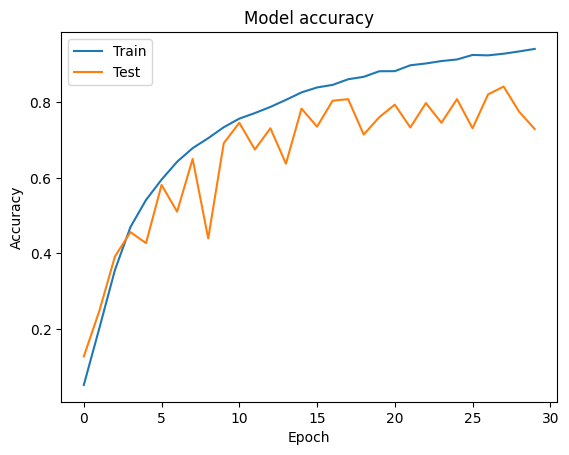

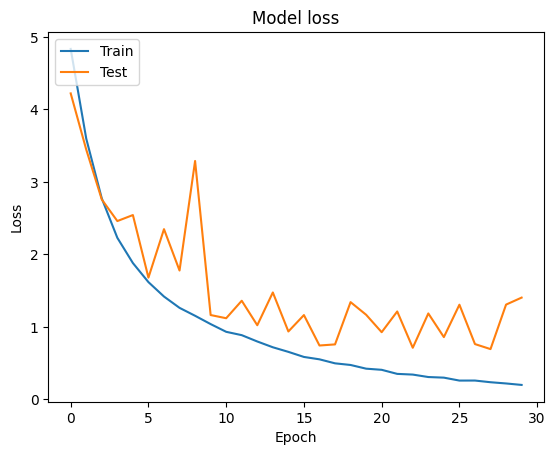

In [ ]:
def plot():
    # Plot training & validation accuracy values

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
plot()

In [ ]:
evaluation =model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

In [ ]:
import tensorflow as tf
new_image = tf.image.decode_jpeg(tf.io.read_file('crow.jpg'))
new_image = tf.image.resize(new_image, (224, 224))
new_image = new_image / 255.0

prediction = model.predict(tf.expand_dims(new_image, axis=0))

# Get the predicted species
predicted_species = prediction.argmax()

# Print the predicted species
print('Predicted species:', predicted_species)

1/1 [==============================] - 2s 2s/step
Predicted species: 31


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(test, predicted_vals > 0.5))

In [ ]:
pd.DataFrame(classification_report(test.classes, predicted_vals > 0.5, output_dict=True))